**Nhận diện số**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
transform = transforms.ToTensor()  # tự đưa về [0,1] và shape (1,28,28)

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


In [ ]:
print(train_ds.data.shape, train_ds.data.dtype)
print(train_ds.targets.shape, train_ds.targets.dtype)


torch.Size([60000, 28, 28]) torch.uint8
torch.Size([60000]) torch.int64


In [ ]:
print(train_ds.data[1])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

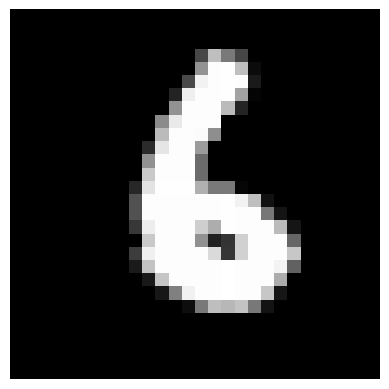

In [ ]:
img = train_ds.data[36]          # (28,28) uint8 0..255
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
x_train = train_ds.data.float().div(255.0).view(-1, 784)
y_train = train_ds.targets.numpy()

x_test = test_ds.data.float().div(255.0).view(-1, 784)
y_test = test_ds.targets.numpy()

print(x_train.shape, y_train.shape)

torch.Size([60000, 784]) (60000,)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

torch.Size([38400, 784]) (38400,)
torch.Size([9600, 784]) (9600,)


In [ ]:
class MLP:
    def __init__(self, input_dim, output_dim=10, lr=0.01, epochs=10000, batch_size=256):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.batch_size = batch_size
        self.list_loss_train = []
        self.list_loss_val = []
        self.best_train_model = None
        self.best_val_model = None

    def train(self, x_train, y_train, x_val, y_val):
        if isinstance(x_train, torch.Tensor):
            x_train_tensor = x_train.float()
        else:
            x_train_tensor = torch.FloatTensor(x_train)

        if isinstance(y_train, torch.Tensor):
            y_train_tensor = y_train.long()
        else:
            y_train_tensor = torch.LongTensor(y_train)

        if isinstance(x_val, torch.Tensor):
            x_val_tensor = x_val.float()
        else:
            x_val_tensor = torch.FloatTensor(x_val)

        if isinstance(y_val, torch.Tensor):
            y_val_tensor = y_val.long()
        else:
            y_val_tensor = torch.LongTensor(y_val)

        n = x_train_tensor.shape[0]

        for epoch in range(self.epochs):
            self.model.train()

            # shuffle index cho mỗi epoch
            perm = torch.randperm(n)

            # --- train theo mini-batch ---
            for start in range(0, n, self.batch_size):
                idx = perm[start:start + self.batch_size]
                xb = x_train_tensor[idx]
                yb = y_train_tensor[idx]

                self.optimizer.zero_grad()
                outputs_train = self.forward(xb)
                loss_train = self.criterion(outputs_train, yb)
                loss_train.backward()
                self.optimizer.step()

            # --- tính loss train/val để lưu + print (giữ y hệt style bạn) ---
            outputs_train_full = self.forward(x_train_tensor)
            loss_train_full = self.criterion(outputs_train_full, y_train_tensor)

            outputs_val = self.forward(x_val_tensor)
            loss_val = self.criterion(outputs_val, y_val_tensor)

            self.list_loss_train.append(loss_train_full.item())
            self.list_loss_val.append(loss_val.item())

            print(f'Epoch [{epoch+1}/{self.epochs}], Loss_train: {loss_train_full.item():.4f}, Loss_val: {loss_val.item():.4f}')

    def forward(self, x):
        outputs = self.model(x)
        return outputs


In [ ]:
model = MLP(input_dim=x_train.shape[1], lr=0.01, epochs=200, batch_size=256)
model.train(x_train, y_train, x_val, y_val)

Epoch [1/200], Loss_train: 2.2966, Loss_val: 2.2967
Epoch [2/200], Loss_train: 2.2838, Loss_val: 2.2835
Epoch [3/200], Loss_train: 2.2653, Loss_val: 2.2646
Epoch [4/200], Loss_train: 2.2334, Loss_val: 2.2321
Epoch [5/200], Loss_train: 2.1686, Loss_val: 2.1660
Epoch [6/200], Loss_train: 2.0110, Loss_val: 2.0058
Epoch [7/200], Loss_train: 1.6304, Loss_val: 1.6199
Epoch [8/200], Loss_train: 1.1330, Loss_val: 1.1159
Epoch [9/200], Loss_train: 0.8569, Loss_val: 0.8363
Epoch [10/200], Loss_train: 0.7149, Loss_val: 0.6936
Epoch [11/200], Loss_train: 0.6244, Loss_val: 0.6024
Epoch [12/200], Loss_train: 0.5632, Loss_val: 0.5409
Epoch [13/200], Loss_train: 0.5180, Loss_val: 0.4964
Epoch [14/200], Loss_train: 0.4845, Loss_val: 0.4647
Epoch [15/200], Loss_train: 0.4564, Loss_val: 0.4380
Epoch [16/200], Loss_train: 0.4343, Loss_val: 0.4165
Epoch [17/200], Loss_train: 0.4162, Loss_val: 0.3999
Epoch [18/200], Loss_train: 0.4024, Loss_val: 0.3854
Epoch [19/200], Loss_train: 0.3873, Loss_val: 0.3722
Ep

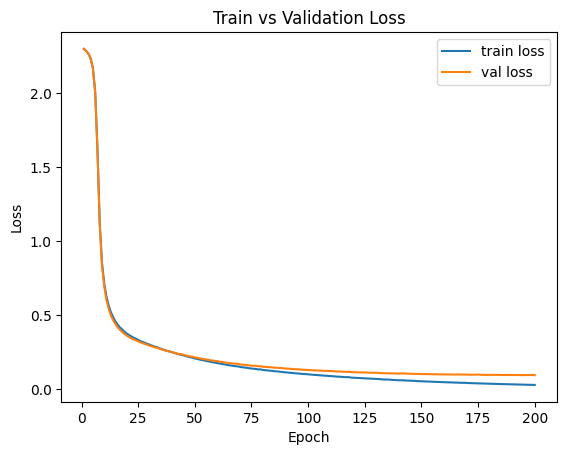

In [ ]:
epochs = range(1, len(model.list_loss_train) + 1)

plt.figure()
plt.plot(epochs, model.list_loss_train, label="train loss")
plt.plot(epochs, model.list_loss_val, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate on test set

if isinstance(x_test, torch.Tensor):
    x_test_tensor = x_test.float()
else:
    x_test_tensor = torch.FloatTensor(x_test)

outputs_test = model.forward(x_test_tensor)

_, predicted = torch.max(outputs_test, 1)   

accuracy = (predicted.numpy() == y_test).mean()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.28%
